## **Library**

In [2]:
import os
import re
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from pathlib import Path
from collections import Counter
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import Sequential, layers, models, regularizers, optimizers, callbacks, mixed_precision

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# check gpu availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Parameters
SR = 22050               # sampling rate
DURATION = 4.0           # target duration (seconds) -> semua file akan dipotong / dipadatkan
N_MELS = 128             # mel bins (freq)
N_FFT = 2048
HOP_LENGTH = 512
EPS = 1e-6
BATCH_SIZE = 32
RANDOM_STATE = 42

## **Data**

In [5]:
# main path
project_root = Path(r"C:\Users\Salim\Kuliah\Semester 5\Jaringan Syaraf Tiruan\Project\Project-JST")
base_dir = str(project_root / "Data" / "IndoWaveSentiment")
output_base = str(project_root / "Data" / "IndoWaveSentiment_Augmented")

In [6]:
audio_folder = r"C:\Users\Salim\Kuliah\Semester 5\Jaringan Syaraf Tiruan\Project\Project-JST\Data\IndoWaveSentiment"

actor_dirs = [f'Actor_{str(i).zfill(2)}' for i in range(1, 11)]
wav_files = []
for actor in actor_dirs:
    actor_path = os.path.join(audio_folder, actor, '*.wav')
    wav_files.extend(glob.glob(actor_path))
print(f"Total WAV files found: {len(wav_files)}")

# load all audio files and print their durations
for file in wav_files[:5]:  # just load first 5 files for demonstration
    audio, sr = librosa.load(file, sr=None)
    duration = len(audio) / sr
    print(f"File: {os.path.basename(file)}, Duration: {duration:.2f} seconds, Sample Rate: {sr} Hz")

# Print statistics about all durations
print("\nLoading all audio files to analyze durations...")
all_durations = []
for file in wav_files:
    audio, sr = librosa.load(file, sr=None)
    duration = len(audio) / sr
    all_durations.append(duration)

print(f"\nDuration Statistics:")
print(f"Total files: {len(all_durations)}")
print(f"Min duration: {min(all_durations):.2f} seconds")
print(f"Max duration: {max(all_durations):.2f} seconds")
print(f"Mean duration: {np.mean(all_durations):.2f} seconds")
print(f"Median duration: {np.median(all_durations):.2f} seconds")

Total WAV files found: 300


c:\Users\loq\anaconda3\envs\tf-audio-gpu\lib\site-packages\librosa\core\intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


File: 01-01-01-01.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-01-02.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-01-03.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-02-01.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-02-02.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz

Loading all audio files to analyze durations...

Duration Statistics:
Total files: 300
Min duration: 3.00 seconds
Max duration: 3.80 seconds
Mean duration: 3.10 seconds
Median duration: 3.00 seconds


In [7]:

# helper: load, pad/trim, compute log-mel spectrogram, normalize per-sample
def file_to_log_mel(path, sr=SR, duration=DURATION, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    y, _sr = librosa.load(path, sr=sr, mono=True)

    # Trim leading/trailing silence (opsional)
    y, _ = librosa.effects.trim(y, top_db=25)

    # Pre-emphasis (opsional untuk menonjolkan frekuensi tinggi)
    y = np.append(y[0], y[1:] - 0.97 * y[:-1])

    target_len = int(sr * duration)
    if len(y) < target_len:
        y = librosa.util.fix_length(y, size=target_len)
    else:
        y = y[:target_len]

    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, power=2.0)
    log_mel = librosa.power_to_db(mel, ref=np.max)

    # Tidak ada normalisasi per-file di sini (akan dilakukan global setelah split)
    return log_mel.astype(np.float32)

## **Labelling**

In [8]:
# label dictionary
label_map = {
    '01': 'neutral',
    '02': 'happy',
    '03': 'surprise',
    '04': 'disgust',
    '05': 'disappointed'
}

# Update wav_files to include both original and augmented files
wav_files_original = []
for actor in actor_dirs:
    actor_path = os.path.join(audio_folder, actor, '*.wav')
    wav_files_original.extend(glob.glob(actor_path))

wav_files = wav_files_original
print(f"Total WAV files: {len(wav_files)}")

def label_from_filename(filename):
    """
    Extract emotion code from filename robustly.
    Finds the first 2-digit token in the name that matches label_map keys.
    """
    fname = os.path.basename(filename)
    match = re.search(r'-(\d{2})-', fname)
    if match:
        code = match.group(1)
        return label_map.get(code, None)
    return None

labels = [label_from_filename(f) for f in wav_files]
print(labels[:10])

Total WAV files: 300
['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'happy', 'happy', 'happy', 'happy']


In [9]:
print(Counter(labels))

Counter({'neutral': 60, 'happy': 60, 'surprise': 60, 'disgust': 60, 'disappointed': 60})


## **Preprocessing**

In [10]:
X_list = []
y_list = []
X_files = []
skipped = []

for fp in wav_files:
    lbl = label_from_filename(fp)
    if lbl == 'unknown':
        skipped.append(fp)
        continue
    try:
        spec = file_to_log_mel(fp)        # (n_mels, t_frames)
        X_list.append(spec)
        y_list.append(lbl)
        X_files.append(fp)
    except Exception as e:
        skipped.append(fp)
        print("Skipped", fp, ":", e)

if len(X_list) == 0:
    raise RuntimeError("No valid spectrograms. Check filenames and label_map.")

# Stack and add channel dim for Conv2D
X = np.stack(X_list, axis=0).astype(np.float32)   # (N, n_mels, t_frames)
X = np.expand_dims(X, -1)                         # (N, n_mels, t_frames, 1)
y = np.array(y_list)

print("Built dataset:", X.shape, "labels:", Counter(y))
if skipped:
    print("Skipped files:", len(skipped), "examples:", skipped[:5])

Built dataset: (300, 128, 173, 1) labels: Counter({'neutral': 60, 'happy': 60, 'surprise': 60, 'disgust': 60, 'disappointed': 60})


In [11]:
# Encode labels -> expect 5 classes
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes found:", le.classes_, "count:", len(le.classes_))
if len(le.classes_) != 5:
    print("Warning: expected 5 emotion classes. Verify label_map and filenames.")

Classes found: ['disappointed' 'disgust' 'happy' 'neutral' 'surprise'] count: 5


### **Splitting**

In [12]:
def group_key(path):
    fname = os.path.basename(path)
    return fname.replace('_aug', '').replace('.wav', '')

groups = np.array([group_key(fp) for fp in X_files])
uniq_groups, group_idx = np.unique(groups, return_inverse=True)

# Label per grup (pastikan konsisten)
group_labels = np.array([y_enc[groups == g][0] for g in uniq_groups])

# Stratified split: 20% test, sisanya train/val 50:50
g_train_val, g_test, _, y_g_test = train_test_split(
    uniq_groups, group_labels, test_size=0.20, stratify=group_labels, random_state=RANDOM_STATE
)
g_train, g_val, _, _ = train_test_split(
    g_train_val, group_labels[np.isin(uniq_groups, g_train_val)], 
    test_size=0.25, stratify=group_labels[np.isin(uniq_groups, g_train_val)], random_state=RANDOM_STATE
)

train_mask = np.isin(groups, g_train)
val_mask   = np.isin(groups, g_val)
test_mask  = np.isin(groups, g_test)

X_train, y_train = X[train_mask], y_enc[train_mask]
X_val,   y_val   = X[val_mask],   y_enc[val_mask]
X_test,  y_test  = X[test_mask],  y_enc[test_mask]

print("Distribusi per split:")
print("train:", Counter(y_train), "total:", len(y_train))
print("val  :", Counter(y_val),   "total:", len(y_val))
print("test :", Counter(y_test),  "total:", len(y_test))

Distribusi per split:
train: Counter({0: 40, 4: 39, 2: 38, 3: 32, 1: 31}) total: 180
val  : Counter({1: 17, 3: 16, 2: 10, 4: 9, 0: 8}) total: 60
test : Counter({3: 12, 4: 12, 1: 12, 2: 12, 0: 12}) total: 60


### **Normalization**

In [13]:
# NORMALISASI PER-FREQUENCY
# mean/std per mel-band (axis 0=batch, 2=time, 3=channel)
mean_freq = np.mean(X_train, axis=(0, 2, 3), keepdims=True)  # (1, n_mels, 1, 1)
std_freq  = np.std(X_train, axis=(0, 2, 3), keepdims=True) + EPS

X_train = (X_train - mean_freq) / std_freq
X_val   = (X_val   - mean_freq) / std_freq
X_test  = (X_test  - mean_freq) / std_freq

print("Normalisasi per-freq OK. Train shape:", X_train.shape)

Normalisasi per-freq OK. Train shape: (180, 128, 173, 1)


In [14]:
from sklearn.utils.class_weight import compute_class_weight

classes_unique = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes_unique,
    y=y_train
)
class_weights = {int(c): float(w) for c, w in zip(classes_unique, class_weights_array)}
print("Class weights:", class_weights)

Class weights: {0: 0.9, 1: 1.1612903225806452, 2: 0.9473684210526315, 3: 1.125, 4: 0.9230769230769231}


## **Modelling**

In [ ]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4050 Laptop GPU, compute capability 8.9
Compute dtype: float16
Variable dtype: float32


In [16]:
class SpecAugment(layers.Layer):
    def __init__(self, freq_masks=2, time_masks=2, freq_max=18, time_max=30, **kwargs):
        super().__init__(**kwargs)
        self.freq_masks = freq_masks
        self.time_masks = time_masks
        self.freq_max = freq_max
        self.time_max = time_max

    def call(self, x, training=None):
        if not training:
            return x
        B = tf.shape(x)[0]; F = tf.shape(x)[1]; T = tf.shape(x)[2]
        d = x.dtype

        for _ in range(self.freq_masks):
            f = tf.random.uniform([], 0, self.freq_max, dtype=tf.int32)
            f0 = tf.random.uniform([], 0, F - f, dtype=tf.int32)
            mask = tf.concat([
                tf.ones([B, f0, T, 1], dtype=d),
                tf.zeros([B, f, T, 1], dtype=d),
                tf.ones([B, F - f0 - f, T, 1], dtype=d)
            ], axis=1)
            x = x * mask

        for _ in range(self.time_masks):
            t = tf.random.uniform([], 0, self.time_max, dtype=tf.int32)
            t0 = tf.random.uniform([], 0, T - t, dtype=tf.int32)
            mask = tf.concat([
                tf.ones([B, F, t0, 1], dtype=d),
                tf.zeros([B, F, t, 1], dtype=d),
                tf.ones([B, F, T - t0 - t, 1], dtype=d)
            ], axis=2)
            x = x * mask

        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "freq_masks": self.freq_masks,
            "time_masks": self.time_masks,
            "freq_max": self.freq_max,
            "time_max": self.time_max
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [39]:
data_augmentation = Sequential([
    layers.GaussianNoise(0.01),  # Noise injection
    layers.RandomContrast(0.2),  # Contrast perturbation
], name='data_augmentation')

In [41]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))
print("Input shape:", input_shape, "Num classes:", num_classes)

model = Sequential([
    layers.Input(shape=input_shape),
    data_augmentation,
    # SpecAugment dengan intensitas lebih rendah
    SpecAugment(freq_masks=1, time_masks=1, freq_max=10, time_max=15),
    
    # Block 1: Ekstraksi fitur low-level
    layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    
    # Block 2: Ekstraksi fitur mid-level
    layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    
    # Block 3: Ekstraksi fitur high-level
    layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.3),
    
    # Global Average Pooling (lebih baik dari Flatten)
    layers.GlobalAveragePooling2D(),
    
    # Dense layers dengan regularisasi
    layers.Dense(256, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    # Output layer
    layers.Dense(num_classes, activation='softmax', dtype='float32')
])

model.summary()

Input shape: (128, 173, 1) Num classes: 5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 128, 173, 1)      0         
 al)                                                             
                                                                 
 spec_augment_2 (SpecAugment  (None, 128, 173, 1)      0         
 )                                                               
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 173, 64)      640       
                                                                 
 batch_normalization_16 (Bat  (None, 128, 173, 64)     256       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 128, 173, 64)      0         
            

In [42]:
optimizer = optimizers.Adam(
    learning_rate=3e-4,
    clipnorm=1.0  # Prevent exploding gradients
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

ckpt_path = "cnn_best.h5"

def lr_schedule(epoch, lr):
    """Cosine annealing schedule"""
    import math
    initial_lr = 3e-4
    min_lr = 1e-6
    decay_epochs = 60
    if epoch < decay_epochs:
        cos_inner = math.pi * epoch / decay_epochs
        return min_lr + 0.5 * (initial_lr - min_lr) * (1 + math.cos(cos_inner))
    return min_lr

# Custom callback untuk monitor per-class accuracy
class PerClassMetrics(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            y_pred = np.argmax(self.model.predict(X_val, verbose=0), axis=1)
            print(f"\n--- Epoch {epoch} Validation Predictions ---")
            print(f"Distribution: {Counter(y_pred)}")
            from sklearn.metrics import classification_report
            print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

cbs = [
    callbacks.ModelCheckpoint(
        ckpt_path, 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max', 
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=20,  # Increased patience
        mode='max', 
        restore_best_weights=True, 
        verbose=1
    ),
    callbacks.LearningRateScheduler(lr_schedule, verbose=1),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    PerClassMetrics()
]

In [74]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=cbs,
    class_weight=class_weights,
    verbose=1,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0003.
Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.9278
Epoch 1: val_accuracy did not improve from 0.81667

--- Epoch 0 Validation Predictions ---
Distribution: Counter({3: 42, 1: 15, 4: 2, 2: 1})
              precision    recall  f1-score   support

disappointed       0.00      0.00      0.00         8
     disgust       0.67      0.59      0.62        17
       happy       1.00      0.10      0.18        10
     neutral       0.38      1.00      0.55        16
    surprise       1.00      0.22      0.36         9

    accuracy                           0.48        60
   macro avg       0.61      0.38      0.34        60
weighted avg       0.61      0.48      0.41        60

6/6 [==============================] - 2s 271ms/step - loss: 0.8264 - accuracy: 0.9278 - val_loss: 3.5470 - val_accuracy: 0.4833 - lr: 3.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0002997

In [75]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

2/2 [==============================] - 0s 23ms/step


## **Evaluation**

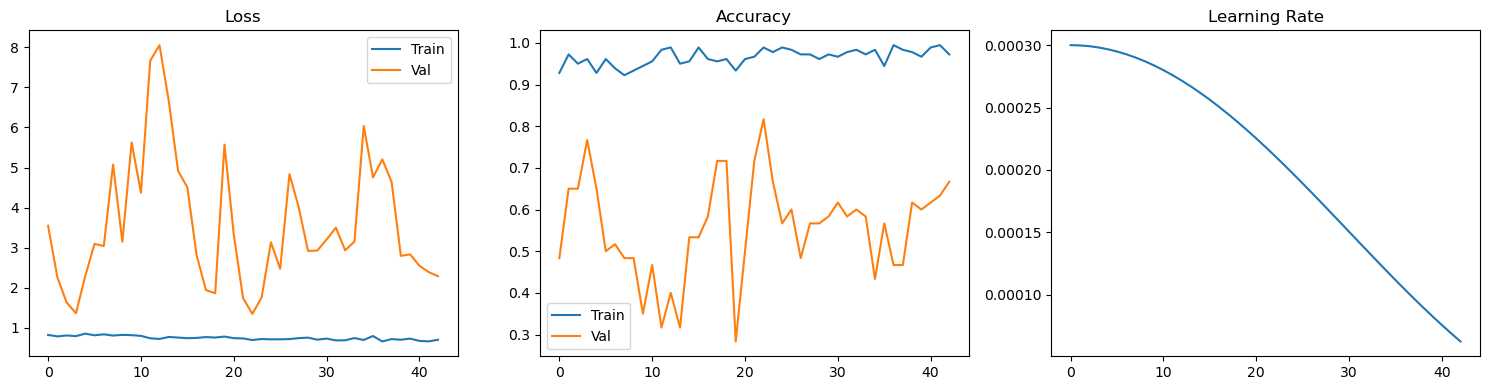

In [76]:
# loss graph
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

# Learning rate history (dari callback)
if 'lr' in history.history:
    plt.subplot(1,3,3)
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.tight_layout()
plt.show()

Test Accuracy: 0.7833
Test Precision: 0.8059
Test Recall: 0.7833
Test F1-Score: 0.7638
Classification report:
              precision    recall  f1-score   support

disappointed       0.80      0.33      0.47        12
     disgust       0.67      0.83      0.74        12
       happy       1.00      0.75      0.86        12
     neutral       0.71      1.00      0.83        12
    surprise       0.86      1.00      0.92        12

    accuracy                           0.78        60
   macro avg       0.81      0.78      0.76        60
weighted avg       0.81      0.78      0.76        60



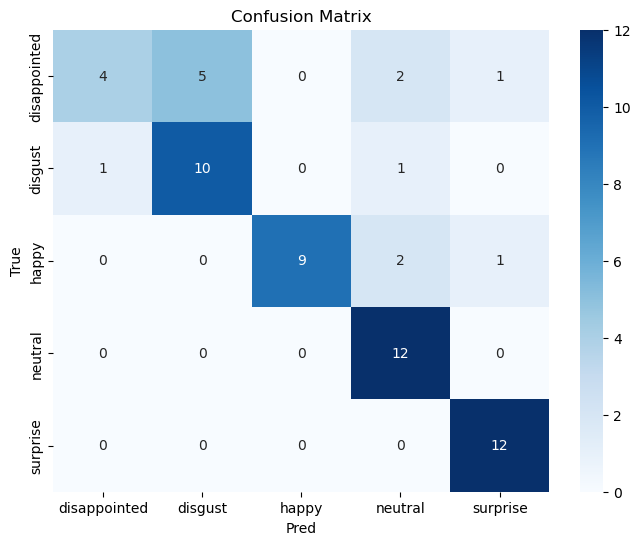

In [77]:
accuracy_score_val = accuracy_score(y_test, y_pred)
precision_score_val = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_score_val = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_score_val = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Test Accuracy: {accuracy_score_val:.4f}")
print(f"Test Precision: {precision_score_val:.4f}")
print(f"Test Recall: {recall_score_val:.4f}")
print(f"Test F1-Score: {f1_score_val:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('True'); plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()